In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Base de Dados - Auto MPG

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

30286/30286 [==============================] - 0s 10us/step


'/home/lucas/.keras/datasets/auto-mpg.data'

In [13]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names = column_names, na_values = "?", 
                          comment = '\t', sep = " ", skipinitialspace = True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [14]:
# limpeza dos dados

In [15]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [16]:
dataset = dataset.dropna()

In [17]:
origin = dataset.pop('Origin')

In [18]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [19]:
# treinamento e teste

In [20]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

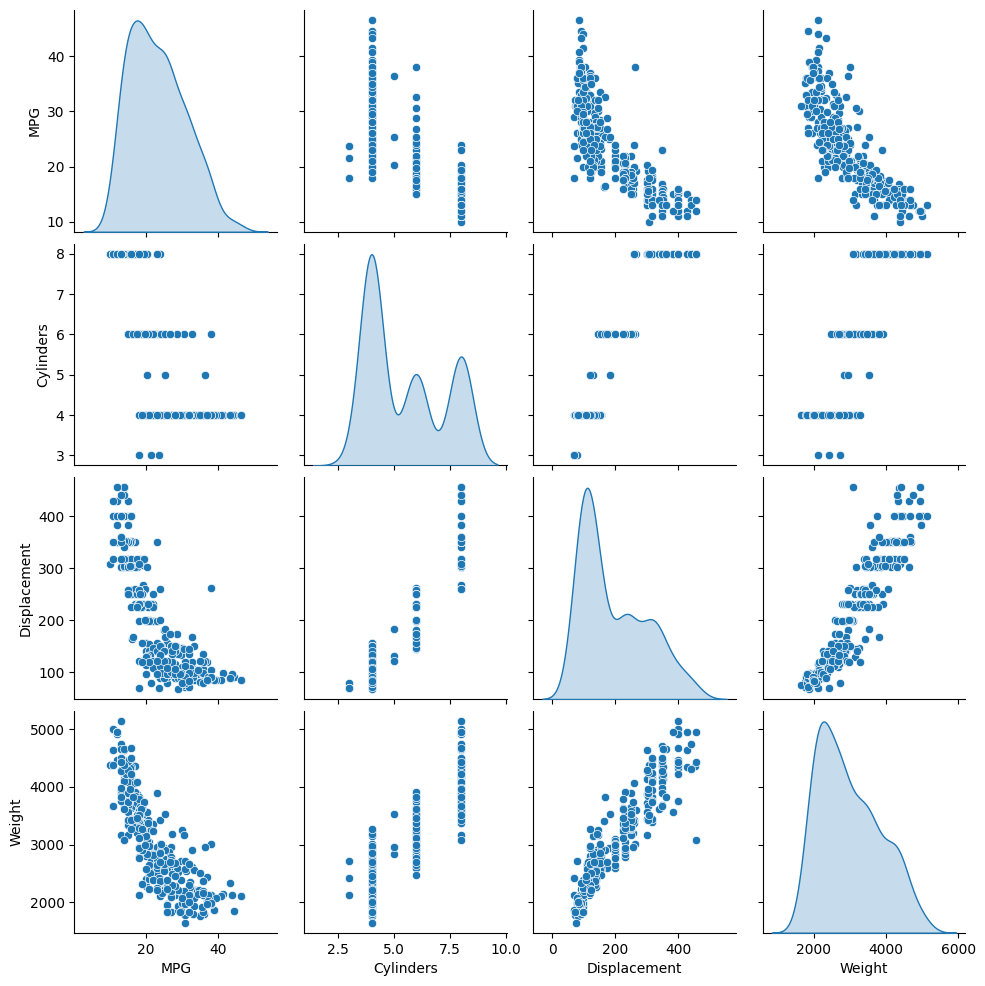

In [21]:
sns.pairplot(train_dataset[["MPG","Cylinders", "Displacement", "Weight"]], diag_kind = "kde")

In [22]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [23]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [24]:
# normalizando dados

In [25]:
def norm(x):    
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [26]:
# modelo

In [29]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    return model

In [31]:
model = build_model()

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [33]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 178ms/step


array([[-0.21567729],
       [-0.39091125],
       [ 0.18010452],
       [-0.7846588 ],
       [-0.723483  ],
       [-0.20656992],
       [-0.78068185],
       [-0.6734926 ],
       [-0.13647321],
       [-0.38702145]], dtype=float32)

In [34]:
# Treinando modelo

In [38]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch % 100 == 0): print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.701518,1.057425,2.701518,8.609343,2.225735,8.609343,995
996,2.558779,1.022723,2.558779,8.665797,2.279704,8.665797,996
997,2.630536,1.020776,2.630536,8.638628,2.262254,8.638628,997
998,2.627540,1.009377,2.627540,8.483827,2.213799,8.483827,998
999,2.659931,1.028038,2.659931,8.968547,2.300444,8.968547,999


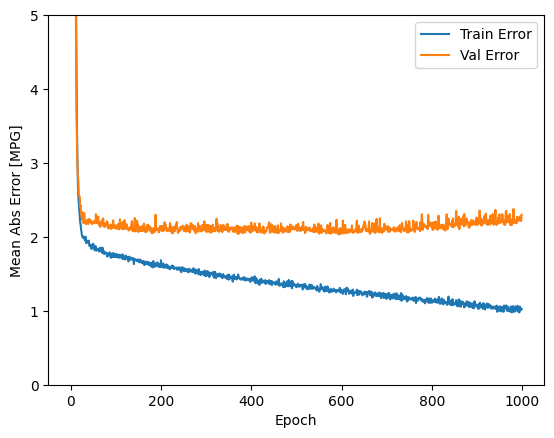

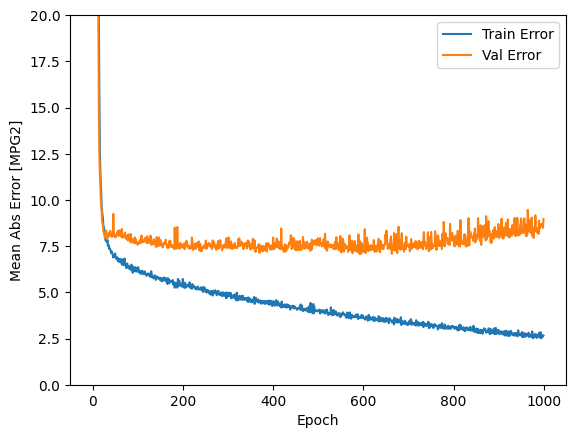

In [43]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mae'],
    label='Train Error')
    
    plt.plot(hist['epoch'],hist['val_mae'],
            label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG2]')
    plt.plot(hist['epoch'],hist['mse'],
    label='Train Error')
    
    plt.plot(hist['epoch'],hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
plot_history(history)


....................................................

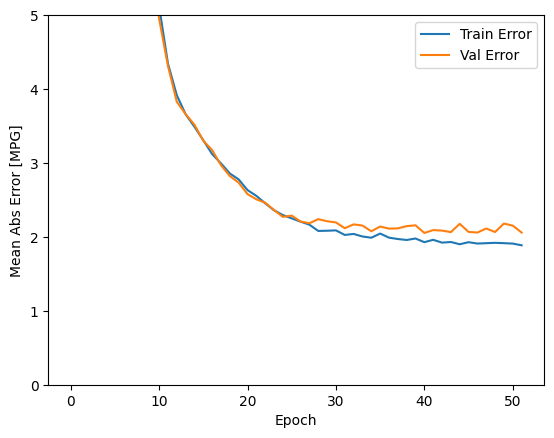

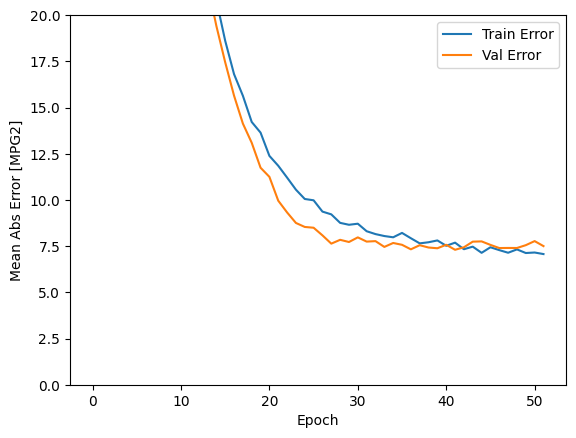

In [45]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs= EPOCHS,
                   validation_split = 0.2, verbose = 0, callbacks= [early_stop, PrintDot()])

plot_history(history)

In [46]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7807 - mae: 1.9151 - mse: 5.7807 - 32ms/epoch - 11ms/step
Testing set Mean Abs Error:  1.92 MPG


3/3 [==============================] - 0s 3ms/step


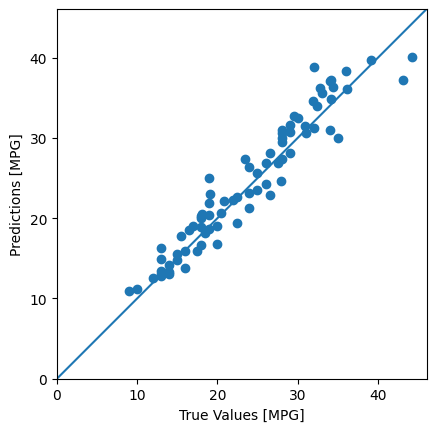

In [47]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.xlim()[1]])
_ = plt.plot([-100, 100], [-100,100])

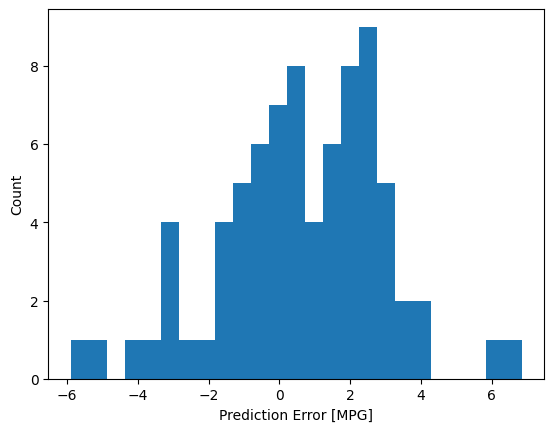

In [48]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")